In [66]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import binom
import pymc3 as pm

In [67]:
# Function to identify B-specific variants
def get_b_specific_variants(df_a, df_b):
    """
    Identify positions where Sample B has a unique homoplasmic variant.
    """
    return df_b[df_b['Allele'] != df_a['Allele']]

# Function to compute expected VAF with error correction
def expected_vaf(X, epsilon=0.01):
    """
    Compute the expected VAF for B-specific variants with sequencing error.
    """
    return (1 - X) * (1 - epsilon) + X * epsilon

# Function to compute the binomial likelihood
def compute_likelihood(dp_alt, dp_total, expected_vaf):
    """
    Compute the binomial likelihood of observing the given VAF.
    """
    return binom.pmf(dp_alt, dp_total, expected_vaf)

# Function to compute the total log-likelihood for a given mixture ratio
def compute_log_likelihood(df_b_specific, df_ab, X, epsilon=0.01):
    log_likelihood = 0
    for i, row in df_b_specific.iterrows():
        pos = row['POS']
        dp_alt = df_ab.loc[df_ab['POS'] == pos, 'DP_minor'].values[0]
        dp_total = df_ab.loc[df_ab['POS'] == pos, ['DP_major', 'DP_minor']].sum(axis=1).values[0]
        
        exp_vaf = expected_vaf(X, epsilon)
        likelihood = compute_likelihood(dp_alt, dp_total, exp_vaf)
        log_likelihood += np.log(likelihood + 1e-10)  # Avoid log(0)
    
    return log_likelihood


In [92]:
# Grid search to find the most probable mixture ratio
def grid_search(df_b_specific, df_ab, X_range, epsilon=0.05):
    log_likelihoods = []
    for X in X_range:
        ll = compute_log_likelihood(df_b_specific, df_ab, X, epsilon)
        log_likelihoods.append(ll)
    return np.array(log_likelihoods)


In [93]:
# Simulate synthetic data for testing
def simulate_data(n_positions=100, X_true=0.98, coverage=500):
    """
    Simulate synthetic data for Samples A, B, and AB based on the given mixture ratio X_true.
    """
    np.random.seed(42)
    positions = np.arange(1, n_positions + 1)
    
    # Randomly assign alleles for Sample A and B
    alleles = np.random.choice(['A', 'C', 'G', 'T'], size=n_positions)
    alleles_b = np.roll(alleles, 1)  # Slightly shift to simulate different alleles for Sample B

    # Calculate the read counts based on the mixture ratio
    dp_minor = np.full(n_positions, int((1 - X_true) * coverage))  # Reads from Sample B
    dp_major = coverage - dp_minor  # Reads from Sample A

    # Create DataFrames for A, B, and AB
    df_a = pd.DataFrame({'POS': positions, 'Allele': alleles, 'DP_major': coverage, 'DP_minor': 0})
    df_b = pd.DataFrame({'POS': positions, 'Allele': alleles_b, 'DP_major': coverage, 'DP_minor': 0})
    df_ab = pd.DataFrame({'POS': positions, 'Allele': alleles, 
                          'DP_major': dp_major, 'DP_minor': dp_minor})

    return df_a, df_b, df_ab



In [97]:
# Run the analysis
df_a, df_b, df_ab = simulate_data(n_positions=100, X_true=0.97, coverage=500)
df_b_specific = get_b_specific_variants(df_a, df_b)

X_range = np.linspace(0.95, 1.00, 100)
log_likelihoods = grid_search(df_b_specific, df_ab, X_range, epsilon=0.001)

best_X = X_range[np.argmax(log_likelihoods)]

In [98]:
df_ab

,POS,Allele,DP_major,DP_minor
0,1,G,485,15
1,2,T,485,15
2,3,A,485,15
3,4,G,485,15
4,5,G,485,15
...,...,...,...,...
95,96,C,485,15
96,97,C,485,15
97,98,T,485,15
98,99,C,485,15


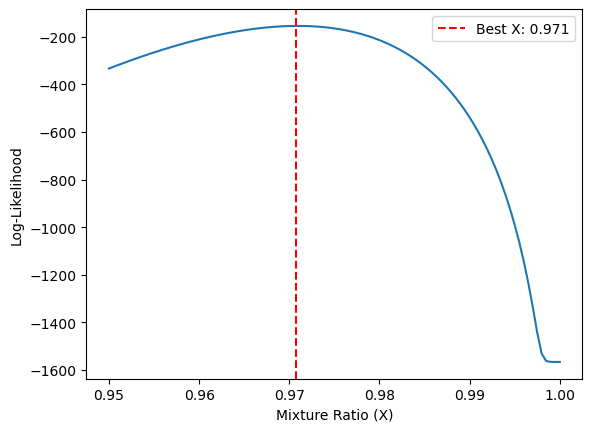

In [99]:
# Plot the log-likelihood curve
plt.plot(X_range, log_likelihoods)
plt.axvline(best_X, color='red', linestyle='--', label=f'Best X: {best_X:.3f}')
plt.xlabel('Mixture Ratio (X)')
plt.ylabel('Log-Likelihood')
plt.legend()
plt.show()

In [54]:
# Output the most probable mixture ratio
print(f"The most probable mixture ratio is: {best_X:.3f}")

The most probable mixture ratio is: 1.000
